<a href="https://colab.research.google.com/github/hamagami/anomaly-detection/blob/main/04_01_knnsample_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k近傍法およびLoF(Local Outlier Factor) による時系列異常検知
サンプル密度を用いて外れ検知を行う方法は，次元がそれほど多くない場合には直観的にわかりやすい方法です。k近傍法(KNN)とそれを一般化したLoFがよく使われています。

### 必要なモジュールのimport

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors #k近傍法
from sklearn.neighbors import LocalOutlierFactor #LoF

### セグメントの切り出し関数

In [ ]:
def getcep(lst,dim):
    ps =np.log(np.abs(np.fft.fft(lst, dim)))#powerspectrum
    cep = np.fft.fft(np.log(ps))#cepstrum
    return ps, cep

In [ ]:
def segdata(lst, dim, mode=0): #lst:１次元系列　dim:セグメントの幅
    emb = np.empty((0,dim), float)#0×dimの空配列
    for i in range(lst.size - dim + 1):#1つづつずらしながらセグメントをつくっている。最後のセグメントの開始点は lst.size-dim
        if mode==1:#ケプストラムを使う場合
           tmp = getcep(lst[i:i+dim],dim)
        else:#波形をそのまま使う場合
           tmp=np.array(lst[i:i+dim][::-1].reshape((1,-1))) #セグメントの切り出し，時系列反転，appendのための2次ベクトル化
        emb = np.append( emb, tmp, axis=0)
    return emb

### データ読み込み，パラメータ設定
 Keoghらの心電図のデータ  http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt
 Keogh, E., Lin, J. and Fu, A.: HOT SAX : Efficiently Finding the Most Unusual Time Series Subsequence, in Proceedings of the Fifth IEEE International Conference on Data Mining, ICDM 05, pp.226-233.

In [ ]:
def getdata():
  !wget "www.dropbox.com/s/x3fmb9mxr4xkip3/qtdbsel102.txt" #ローカルにコピーしてくる
  LEN=3000  #分析区間

  SP=0         #学習用データの開始点
  AP=3000   #テスト用データの開始点　個のデータの場合 4250ポイント付近に異常がある
  data = np.loadtxt("qtdbsel102.txt",delimiter="\t")
  print("データ数:",data.shape[0],"  次元数:",data.shape[1])

  #元データは3次元の時系列，3次のデータ(indexとしては2)を指定して学習/テストデータに分割
  train_org = data[SP:SP+LEN, 2]      #学習用データとして 1～2999サンプル区間を使用
  test_org  = data[AP:AP+LEN, 2]    #テスト用データとして3000～5999サンプルを使用
  
  #x軸
  x=np.arange(SP,SP+LEN)

  return x, train_org, test_org

In [ ]:
x, train_org, test_org = getdata()

plt.plot(x,train_org)
plt.title("train")
plt.legend()
plt.show()
plt.plot(x,test_org)
plt.title("test with anomaly")
plt.legend()
plt.show()

In [ ]:
# 波形をそのまま扱う場合
WLEN=256 #セグメントのサイズ
train_seg = segdata(train_org, WLEN,mode=1)
test_seg  = segdata(test_org, WLEN,mode=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


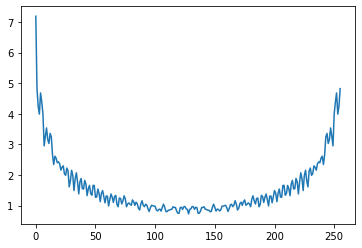

In [ ]:
plt.plot(train_seg[0])

## k近傍学習（学習データ）

In [ ]:
nk = 1#近傍数
knn = NearestNeighbors(n_neighbors=nk)
knn.fit(train_seg)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                 radius=1.0)

## LoF

In [ ]:
lof = LocalOutlierFactor(n_neighbors=nk,
                           novelty=True,
                           contamination=0.1)
lof.fit(train_seg) # train_dataは正常データが大多数であるような訓練データ

LocalOutlierFactor(algorithm='auto', contamination=0.1, leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=1, novelty=True, p=2)

## 未知データに対する評価

## knnの結果

In [ ]:
# knn.fitで使った学習データを用いてk近傍距離(0次に格納される)を求める
dist = knn.kneighbors(test_seg)[0]
# 最大距離で正規化しておく。つまり0～1.0にboundする。
dist= dist/np.max(dist)

## LoFの結果

In [ ]:
# lof
prediction = lof.predict(test_seg) # テストデータに対する予測
score = lof.score_samples(test_seg) # テストデータの異常度
score=score/np.min(score)

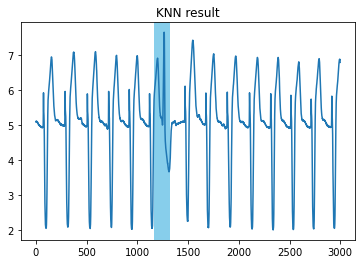

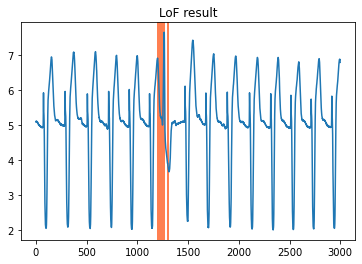

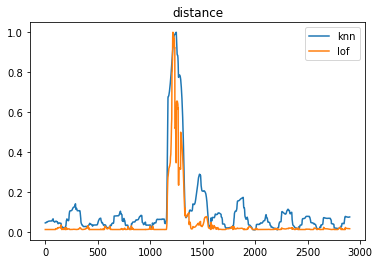

In [ ]:
#テストデータ
plt.title("KNN result")
outlier_rows = [i for i in range(len(dist)) if dist[i]>0.4]
for c in outlier_rows:
    plt.axvspan(c, c, color = "skyblue")

plt.plot(test_org)
plt.show()

plt.title("LoF result")
outlier_rows = [i for i in range(len(score)) if score[i]>0.4]
for c in outlier_rows:
    plt.axvspan(c, c, color = "coral")
plt.plot(test_org)
plt.show()


#距離データ
plt.title("distance")
plt.plot(dist,label="knn")
plt.plot(score,label="lof")
plt.legend()
plt.show()